## A Deep Learning Tool for Automated Landmark Annotation on Hip and Pelvis Radiographs: Training

This is a notebook demonstrating the training process for a model tasked with segmenting twenty two difference structures and landmarks of hip and pelvis radiographs. The training data includes a variety of hip and pelvis images with both preoperative and total hip arthroplasty postoperative joints. The main challenge of this task is achieving high performance over highly variable inputs.

In [1]:
import os
import time
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import datetime
import numpy as np
import monai
from monai.data import ArrayDataset, decollate_batch
from monai.config import print_config
from monai.metrics import DiceMetric
from monai.losses import DiceFocalLoss
from monai.transforms import (
    Activations,
    AsDiscrete,
    AddChannel,
    Compose,
    LoadImage,
    ToTensor,
    RandRotate90,
    RandAffine,
    RandGaussianNoise,
    RandSpatialCrop,
    RandShiftIntensity,
    ScaleIntensity,
    EnsureChannelFirst,
    SpatialPad,
    SqueezeDim
)
from scipy import ndimage
from skimage.measure import (
    label,
    regionprops
)
from skimage import img_as_int
from anatomical_structs import anatomical_labels_dict
from utils import (
    remove_background,
    dilate_points_lines
)

print_config()

MONAI version: 1.0.1
Numpy version: 1.23.3
Pytorch version: 1.12.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8271a193229fe4437026185e218d5b06f7c8ce69
MONAI __file__: /home/m274639/miniconda3/envs/pt/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.2
Pillow version: 9.2.0
Tensorboard version: 2.9.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.13.1
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.4.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#insta

The current structure of the data directory is each image is its own folder - within the folder there are four files. 1. The radiograph itself in Nifti format - and is also pre-padded and resized to 512x512, 2. The flattened annotations also in nifti format, 3. A .csv file with the details of the annotation, 4. The annotations in a .txt file (this may be for Slicer purposes). We generate a list of the mask and image files by first checking if the file name ends with `Mask.nii` which would indicate a mask file. If not, but the file still ends with `.nii`, then it is the image file. 

In [2]:
base_path = "REDACTED" # Path to Dataset

mask_files = []
image_files = []
for (dirpath, dirnames, filenames) in os.walk(base_path):
    for file in filenames:
        if file.endswith("Mask.nii"):
            mask_files.append(os.path.join(dirpath, file))
        elif file.endswith(".nii"):
            image_files.append(os.path.join(dirpath, file))


## Grab a random set of validation images by sampling 20% of the total indices

val_indices = random.sample(range(0, len(image_files)), int(0.2 * len(image_files)))

image_train = [e for i, e in enumerate(image_files) if i not in val_indices]
mask_train = [e for i, e in enumerate(mask_files) if i not in val_indices]
image_val = [image_files[i] for i in val_indices]
mask_val = [mask_files[i] for i in val_indices]

print("Number of total image files: {}".format(len(image_files)))
print("Number of total mask files: {}".format(len(mask_files)))
print("Number of training image files: {}".format(len(image_train)))
print("Number of training mask files: {}".format(len(mask_train)))
print("Number of validation image files: {}".format(len(image_val)))
print("Number of validation mask files: {}".format(len(mask_val)))

Number of total image files: 1008
Number of total mask files: 1008
Number of training image files: 807
Number of training mask files: 807
Number of validation image files: 201
Number of validation mask files: 201


We define the deterministic and random transforms we use to get the image into the correct format for our model and also for image augmentation to increase the practical size of our dataset. MONAI ensures that random transforms applied to the base image are also applied to the corresponding segmentation.


In [3]:
## Define our transforms for both the images and the segmentations.
## We are using MONAI so any random effect should retain its
## state for both the image and the segmentation,
## which otherwise would result in nonsensical annotations

train_imtrans = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        RandSpatialCrop((408,408), random_size=True),
        RandAffine(prob=0.5, shear_range=(0.5,0.5), padding_mode='zeros'),
        SpatialPad(spatial_size=(512,512)),
        RandShiftIntensity(offsets=20),
        RandGaussianNoise(),
        ScaleIntensity(),
        ToTensor()
    ]
)

## Do not scale intensity for the segmentations
train_segtrans = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        SqueezeDim(dim=3),
        RandSpatialCrop((408,408), random_size=True),
        RandAffine(prob=0.5, shear_range=(0.5,0.5), padding_mode='zeros', mode='nearest'),
        SpatialPad(spatial_size=(512,512)),
        ToTensor()
    ]
)

train_imtrans.set_random_state(seed=0)
train_segtrans.set_random_state(seed=0)

val_imtrans = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        ToTensor()
    ]
)

## Do not scale intensity for the segmentations
val_segtrans = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        SqueezeDim(dim=3),
        ToTensor()
    ]
)

post_trans = Compose(
    [
        Activations(sigmoid=True), 
        AsDiscrete(threshold=0.5)
    ]
)

train_data = ArrayDataset(image_train, train_imtrans, mask_train, train_segtrans)
val_data = ArrayDataset(image_val, val_imtrans, mask_val, val_segtrans)

train_loader = monai.data.DataLoader(train_data, batch_size=4, num_workers=4, shuffle=False)
val_loader = monai.data.DataLoader(val_data, batch_size=1, num_workers=4, pin_memory=True, shuffle=True)

/home/m274639/miniconda3/envs/pt/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


Let's take a look at a few images and masks from our training data set - with the transforms

(-0.5, 511.5, 511.5, -0.5)

<Figure size 1500x1500 with 0 Axes>

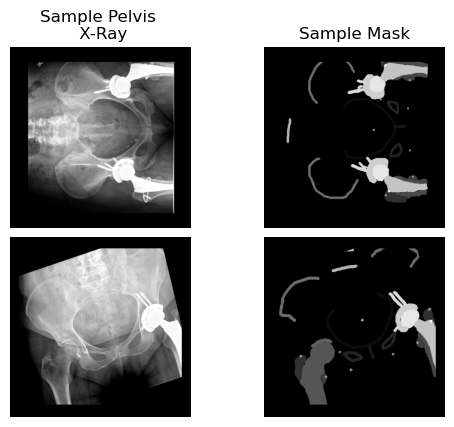

In [4]:
sample_img, sample_mask = monai.utils.misc.first(train_loader)

plt.figure(figsize=(15,15))

fig, axarr = plt.subplots(2,2)
plt.subplots_adjust(
    hspace=0.05,
    wspace=0.05,
)
axarr[0,0].imshow(ndimage.rotate(sample_img[0][0], 90), cmap=plt.cm.gray)
axarr[0,0].set_title("Sample Pelvis \n X-Ray")
axarr[0,0].axis('off')

axarr[1,0].imshow(ndimage.rotate(sample_img[1][0], 90), cmap=plt.cm.gray)
axarr[1,0].set_title("")
axarr[1,0].axis('off')

axarr[0,1].imshow(ndimage.rotate(sample_mask[0][0], 90), cmap=plt.cm.gray)
axarr[0,1].set_title("Sample Mask")
axarr[0,1].axis('off')

axarr[1,1].imshow(ndimage.rotate(sample_mask[1][0], 90), cmap=plt.cm.gray)
axarr[1,1].set_title("")
axarr[1,1].axis('off')


The following structures, if they are present in the image, will be annotated:

Anatomy Outline:
1. Pelvic ring from SI joint to SI joint (line)
2. Pubic symphysis (line)
3. Obturator rings (line)
4. Greater trochanter (segment)
5. Lesser trochanter (segment)
6. Femur on implant side (segment)
7. Femur on no-implant side (segment)
8. Subchondral bone on the acetabulum on the no-implant side (line)
9. Iliac crest from ASIS posteriorly to SI joint (line)
10. Teardrops (point)
11. The most inferior aspects of the ischium (point)
12. The medial most point on the lesser trochanter (point)
13. The superior most point on the greater trochanter (point)
14. The center of sacrococcygeal junction (point)
15. Vertebral endplates (line)
 
Implant Outline:

16. Femoral component (segment)
17. Acetabular component (segment)
18. Screws (segment)
19. Femoral Head (segment)
20. The distal tip of the femoral stem (point)
21. The superior lateral most corner of the femoral component (point)

Others:

22. Mag Markers (if present) (segment)


Let's visualize the individual components by converting the flattened annotation mask image into a 22 channel image, one channel for each structure. The model will output 22 channels, so this is how we will calculate the Dice scores for the outputs anyway.


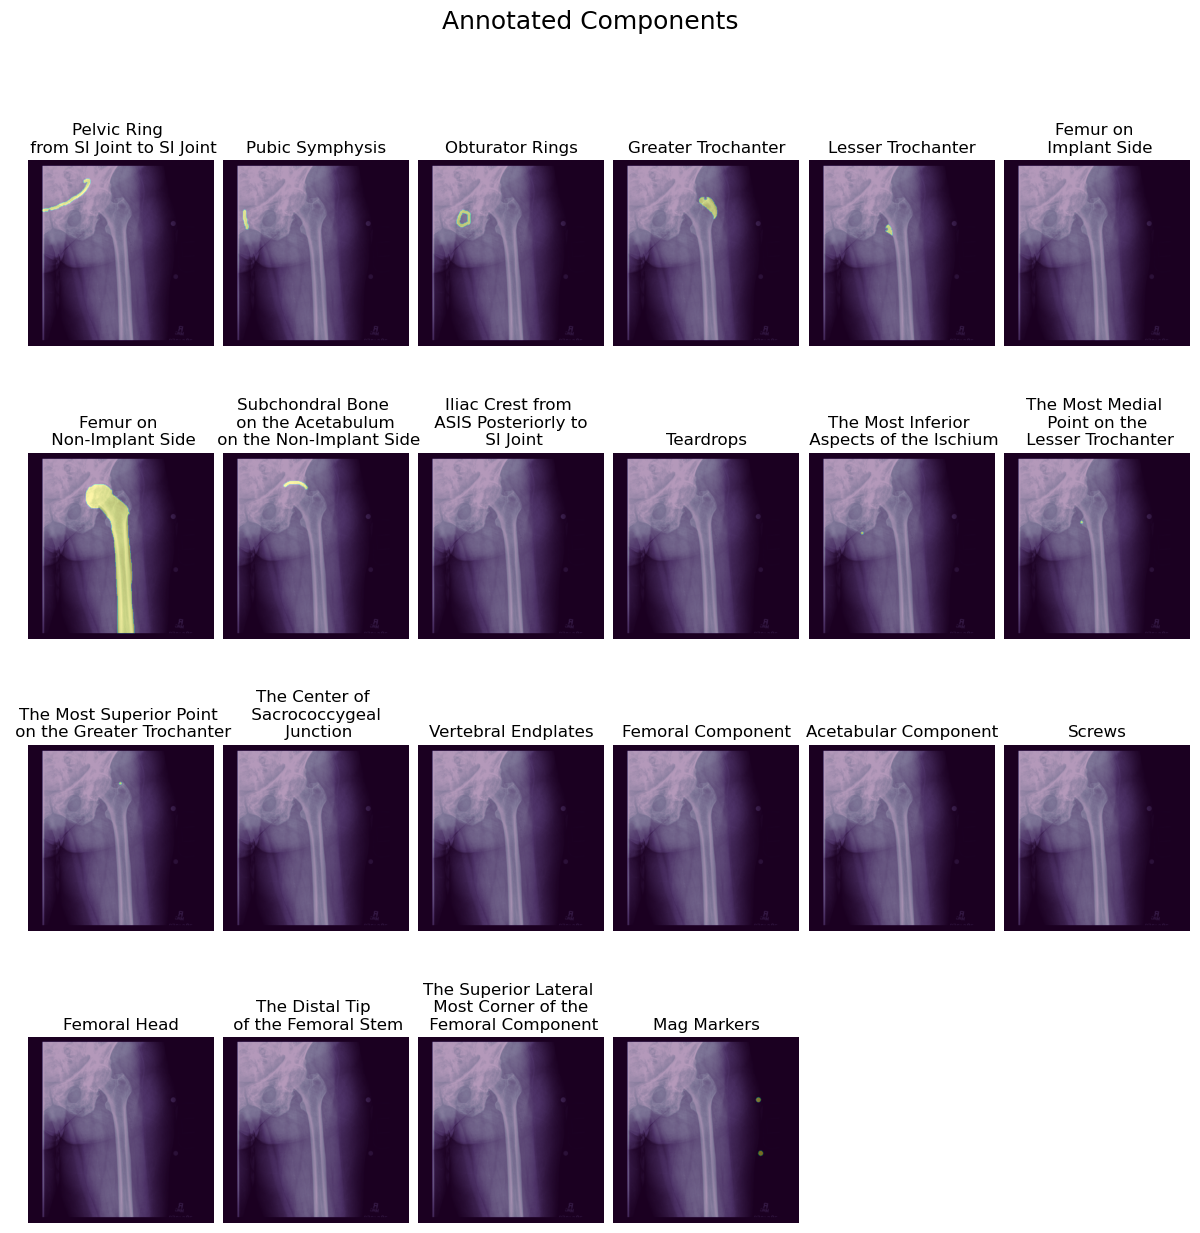

In [5]:
seg_onehot = remove_background(sample_mask ,23)
num_classes = seg_onehot.size(dim=1)

plt.figure( figsize=(15,15))
plt.subplots_adjust(
    hspace=0.05,
    wspace=0.05,
)
plt.suptitle("Annotated Components", fontsize=18, y=0.95)

ncols = 6
nrows = num_classes // ncols + (num_classes % ncols > 0)

for n in range(num_classes):
    ax = plt.subplot(nrows, ncols, n + 1)
    ax.imshow(sample_img[3][0], cmap=plt.cm.bone)
    ax.imshow(seg_onehot[3][n], alpha=0.4)
    ax.axis('off')
    ax.set_title(anatomical_labels_dict[n]["name_formatted"])



Due to the small size of the point structures, we dilate them by two pixels in each direction.

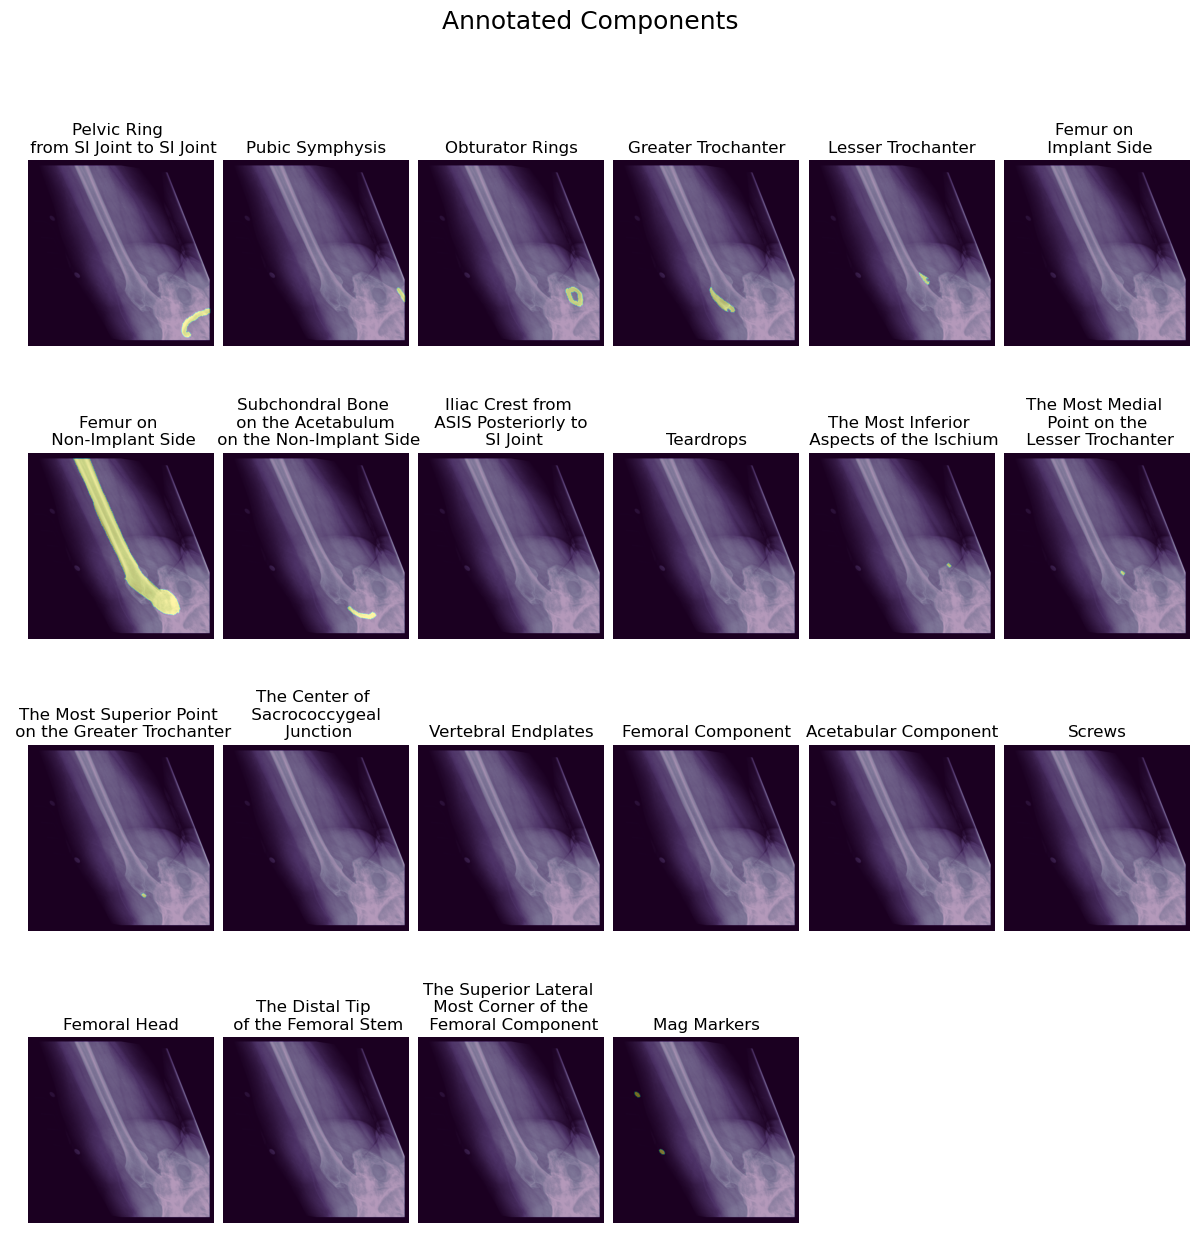

In [8]:
smp_dil, smp_dil_mask = monai.utils.misc.first(train_loader)
smp_dil_mask = remove_background(smp_dil_mask, num_classes=23)
BATCH_SIZE = smp_dil.size(dim=0)
NUM_CLASSES = len(anatomical_labels_dict)
smp_dil_mask = dilate_points_lines(smp_dil_mask, BATCH_SIZE, NUM_CLASSES)
            
plt.figure( figsize=(15,15))
plt.subplots_adjust(
    hspace=0.05,
    wspace=0.05,
)
plt.suptitle("Annotated Components", fontsize=18, y=0.95)

ncols = 6
nrows = num_classes // ncols + (num_classes % ncols > 0)

for n in range(num_classes):
    ax = plt.subplot(nrows, ncols, n + 1)
    ax.imshow(smp_dil[3][0], cmap=plt.cm.bone)
    ax.imshow(smp_dil_mask[3][n], alpha=0.4)
    ax.axis('off')
    ax.set_title(anatomical_labels_dict[n]["name_formatted"])


### The Model

Here we load the model and set up our loss and optimizer

In [11]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "Segmentation-UNet-Dilate2"
MODEL_CREATE_TIME = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=22,
    channels=(
        16, 16, 16, 
        32, 32, 32, 
        64, 64, 64, 
        128, 128, 128, 
        512, 512, 512, 
        1024, 1024, 1024,
        2048
    ),
    strides=(
        1, 1, 2,
        1, 1, 2, 
        1, 1, 2,
        1, 1, 2,
        1, 1, 2,
        1, 1, 2
    ),
    dropout=0.15,
    num_res_units=3
)

loss_function = DiceFocalLoss(
    smooth_nr=0,
    smooth_dr=1e-5,
    squared_pred=True,
    to_onehot_y=False, 
    sigmoid=True, 
    focal_weight=0.3,
    include_background=True # True because we have function to remove it
)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-5
)

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=100
)

dice_metric = DiceMetric(
    include_background=True,
    reduction="mean"
)

dice_metric_batch = DiceMetric(
    include_background=True,
    reduction="mean_batch"
)

model.to(device)

scaler = torch.cuda.amp.GradScaler()
torch.backends.cudnn.benchmark = True

In [12]:
## Set up code for TensorBoard

log_dir = os.path.join("runs", MODEL_NAME + MODEL_CREATE_TIME)
writer = SummaryWriter(log_dir)

layout = {
    "Loss & Dice": {
        "loss": ["Multiline", ["loss/train", "loss/validation"]],
        "dice": ["Multiline", ["dice/train", "dice/validation"]],
    },
}

writer.add_custom_scalars(layout)

In [13]:
MAX_EPOCHS = 100
VAL_INTERVAL = 1 # Number of epochs before running the validation set
best_val_dice = -1

for epoch in tqdm(range(MAX_EPOCHS)):

    ## Set model to train mode
    model.train()

    ## Initialize epoch loss
    epoch_train_loss = 0
    epoch_start = time.time()

    ## Keep track of steps within the epoch
    step = 0
    step_start = time.time()

    ## Train loop
    for train_inputs, train_labels in train_loader:     
        
        ## Increment steps
        step += 1

        batch_size = train_inputs.size(dim=0)
        
        ## Send input and labels to GPU
        train_inputs = train_inputs.to(device)
        train_labels = train_labels.to(device)
        train_labels = remove_background(train_labels, 23).cpu()
        train_labels = dilate_points_lines(
            train_labels, batch_size, 22
        ).to(device)
        
        ## Model forward + backward steps
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            train_outputs = model(train_inputs)
            train_loss = loss_function(train_outputs, train_labels)
            train_outputs = [post_trans(i) for i in decollate_batch(train_outputs)]
        scaler.scale(train_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        ## Calculate per image metrics metrics
        dice_metric(train_outputs, train_labels)
        epoch_train_loss += train_loss.item()
    
    # Calculate per batch metrics
    epoch_train_dice = dice_metric.aggregate().item()
    dice_metric.reset()
    epoch_train_loss /= step

    ## Once per epoch, update learning rate scheduler
    lr_scheduler.step()

    ## Validation loop
    if (epoch + 1) % VAL_INTERVAL == 0:
        model.eval()
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                
                # Run data through model
                val_batch_size = val_inputs.size(dim=0)
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                with torch.cuda.amp.autocast():
                    val_outputs = model(val_inputs)
                    
                # Process ground truth labels       
                val_labels = remove_background(val_labels, 23).cpu()
                val_labels = dilate_points_lines(
                    val_labels, val_batch_size, 22
                ).to(device)
                
                # Calculate Val Loss and Dice               
                val_loss = loss_function(val_outputs, val_labels)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            # Aggregate Metrics over Validation Set
            val_dice = dice_metric.aggregate().item()
            val_dice_batch = dice_metric_batch.aggregate().tolist()
            dice_metric.reset()
            dice_metric_batch.reset()

            # Save Model and Dice Metrics if Model is Highest Performing
            if val_dice > best_val_dice:
                best_val_dice = val_dice
                torch.save(
                    model.state_dict(),
                    os.path.join("checkpoints", MODEL_NAME + MODEL_CREATE_TIME + ".pth"),
                )

            # Write metrics from epoch to tensorboard
            for i in range(len(anatomical_labels_dict)):
                writer.add_scalar("Structure Dice/" + anatomical_labels_dict[i]["name"], val_dice_batch[i], epoch)
            writer.add_scalar('loss/train', epoch_train_loss, epoch)
            writer.add_scalar('loss/validation', val_loss, epoch)
            writer.add_scalar('dice/train', epoch_train_dice, epoch)
            writer.add_scalar('dice/validation', val_dice, epoch)

100%|██████████| 100/100 [4:08:09<00:00, 148.89s/it] 


Now we can check the output of the model - optionally loading in model weights.

In [8]:
model.load_state_dict(torch.load(os.path.join("checkpoints", "HipModel-20220825-162749.pth")))

<All keys matched successfully>

(22, 512, 512)


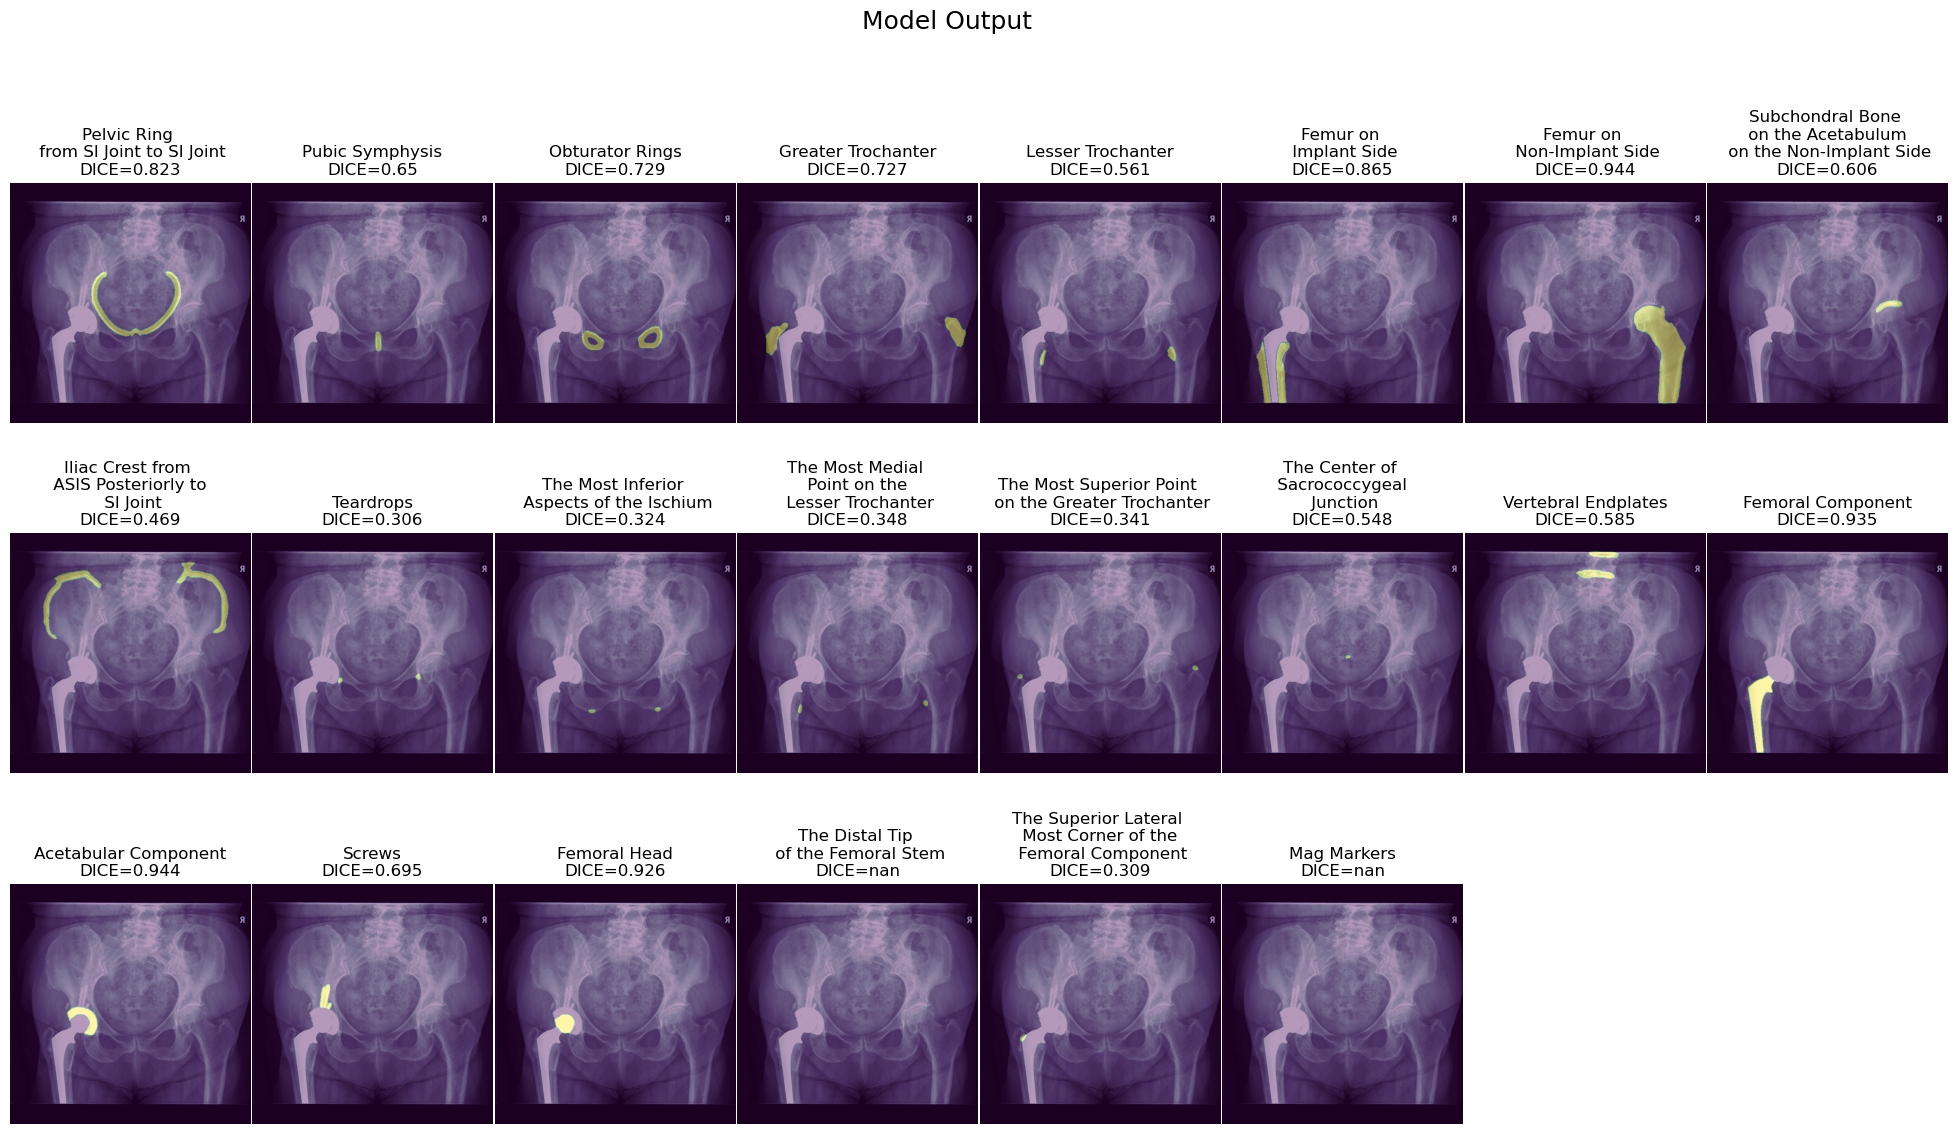

In [15]:
example_image, example_labels = next(iter(val_loader))

example_dice_metric = DiceMetric(
    include_background=True,
    reduction="mean"
)

example_dice_metric_batch = DiceMetric(
    include_background=True,
    reduction="none"
)

model.eval()
with torch.no_grad():
    
    # Send data to device
    example_batch_size = example_labels.size(dim=0)
    example_image = example_image.to(device)
    example_labels = example_labels.to(device)
    
    # Run data through model and dilate labels
    with torch.cuda.amp.autocast():
        example_outputs = model(example_image)       
        example_labels = remove_background(example_labels, 23).cpu()
        example_labels = dilate_points_lines(
            example_labels, example_batch_size, 22
        ).to(device)  
        
    # Process output and calculate metrics
    example_outputs = [post_trans(i) for i in decollate_batch(example_outputs)]
    example_dice_metric(y_pred=example_outputs, y=example_labels)
    example_dice_metric_batch(y_pred=example_outputs, y=example_labels)

# Aggregate metrics
example_dice = example_dice_metric.aggregate().item()
example_dice_batch = example_dice_metric_batch.aggregate().tolist()

# Make figure
plt.figure( figsize=(25,18))
plt.subplots_adjust(
    hspace=0.05,
    wspace=.01,
)
plt.suptitle("Model Output", fontsize=18, y=0.95)

for n in range(num_classes):
    ax = plt.subplot(nrows, 8, n + 1)
    mask = example_outputs[0].cpu()[n]
    ax.imshow(ndimage.rotate(example_image[0].cpu()[0],90), alpha=1.0, cmap=plt.cm.bone)
    ax.imshow(ndimage.rotate(mask,90), alpha=0.4)
    ax.axis('off')
    ax.set_title(anatomical_labels_dict[n]["name_formatted"] + f"\nDICE={round(example_dice_batch[0][n],3)}")

#plt.savefig(os.path.join("output", "best_model_output"), facecolor='w', dpi=300)